In [1]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2, L1, L2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, BinaryCrossentropy
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt

In [2]:
start_time = utility.time.time()

stop_thread = False

# global parameters
max_cpu_usage = 0
max_memory_usage = 0

def collect_cpu_mem_usage():
    global max_cpu_usage, max_memory_usage

    while not stop_thread:
        # Get current CPU and memory usage
        cpu_usage = utility.psutil.cpu_percent()
        memory_usage = utility.psutil.virtual_memory().percent

        # Initialize variables if not yet assigned
        if max_cpu_usage is None:
            max_cpu_usage = cpu_usage
        if max_memory_usage is None:
            max_memory_usage = memory_usage

        # Update maximum values if needed
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_memory_usage = max(max_memory_usage, memory_usage)

        # Sleep for a short interval (adjust as needed)
        utility.time.sleep(1)

# Start the function in a separate thread
thread = utility.threading.Thread(target=collect_cpu_mem_usage)
thread.start()

In [3]:
train_data, test_data, val_data, train_labels, test_labels, val_labels, test_true_labels, anom_data = utility.preprocess_data(True, n_anomalies=12000, n_samples=-1)

345
Splitting data
normalize data
Reshape data
Convert data
Add anomalies


In [4]:
train_data, train_remainder, train_labels, train_remainder = train_test_split(train_data, train_labels, test_size=0.40, random_state=42)

In [5]:
# data shape
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

# labels shape
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)
print(test_true_labels.shape)

(18153455, 784)
(10097253, 784)
(10085254, 784)
(18153455,)
(10097253,)
(10085254,)
(10097253,)


Dataset split: 18153455 train rows
Dataset split: 18153455 test rows


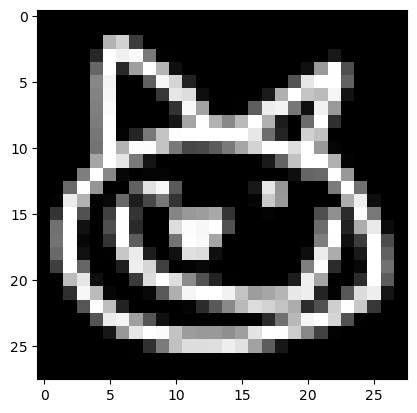

In [6]:
print(f"Dataset split: {len(train_data)} train rows")
print(f"Dataset split: {len(train_labels)} test rows")

point = train_data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [7]:
# Best Hyperparameters:
# {'optimizer': 'adam', 'activation': 'tanh', 'dropout_rate': 0.2, 'epochs': 150, 'batch_size': 4096}
# Best Validation Loss: 0.09276054799556732

In [8]:
# parameters
epochs = 300
batch_size = 2048
optimizer = 'adam'
loss = MeanSquaredError()
dropout_rate = 0
activation = 'tanh'

In [9]:
latent_dim = 2

In [10]:
# encoder
vae_input = Input(shape=(784,))
x = Dense(512, activation='relu')(vae_input)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
x = Dropout(rate=dropout_rate)(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

In [11]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
z = Lambda(lambda x: sampling(x))([z_mean, z_log_var])

In [13]:
# decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(32, activation='relu')(decoder_input)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(784, activation=activation)(x)
decoded = x

In [14]:
# Encoder model
encoder = Model(inputs=vae_input, outputs=[z_mean, z_log_var, z])

# Decoder model
decoder = Model(inputs=decoder_input, outputs=decoded)

In [15]:
vae_output = decoder(encoder(vae_input)[2])
vae = Model(inputs=vae_input, outputs=vae_output)

In [16]:
vae.compile(optimizer=optimizer, loss=loss)

In [17]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with early stopping
history = vae.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, shuffle=True,
                          validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/300
8864/8864 [==============================] - 453s 51ms/step - loss: 0.0683 - val_loss: 0.0670
Epoch 2/300
8864/8864 [==============================] - 336s 38ms/step - loss: 0.0660 - val_loss: 0.0660
Epoch 3/300
8864/8864 [==============================] - 335s 38ms/step - loss: 0.0656 - val_loss: 0.0655
Epoch 4/300
8864/8864 [==============================] - 332s 37ms/step - loss: 0.0655 - val_loss: 0.0650
Epoch 5/300
8864/8864 [==============================] - 331s 37ms/step - loss: 0.0652 - val_loss: 0.0658
Epoch 6/300
8864/8864 [==============================] - 331s 37ms/step - loss: 0.0655 - val_loss: 0.0674
Epoch 7/300
8864/8864 [==============================] - 329s 37ms/step - loss: 0.0658 - val_loss: 0.0655
Epoch 8/300
8864/8864 [==============================] - 332s 37ms/step - loss: 0.0657 - val_loss: 0.0657
Epoch 9/300
8864/8864 [==============================] - 328s 37ms/step - loss: 0.0658 - val_loss: 0.0658
Epoch 10/300
8864/8864 [======================

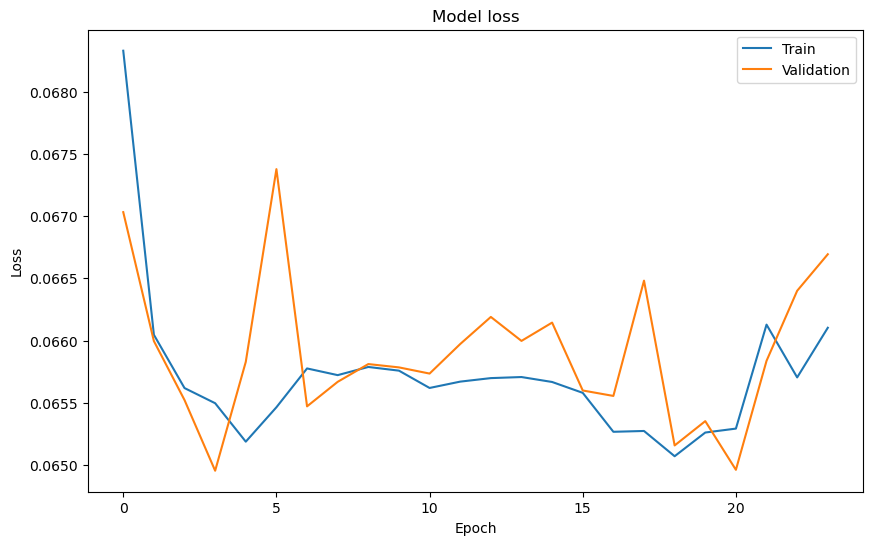

In [18]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [19]:
def generate_reconstructions(model, input_data, batch_size=2048):
    num_samples = input_data.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    # Initialize an empty array to store reconstructions
    all_reconstructions = np.empty_like(input_data)

    # Generate reconstructions in batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        # Extract a batch of data
        batch_data = input_data[start_idx:end_idx]

        # Generate reconstructions for the batch
        batch_reconstructions = model.predict(batch_data)

        # Store the reconstructions in the corresponding indices
        all_reconstructions[start_idx:end_idx] = batch_reconstructions

    return all_reconstructions

20/20 [==============================] - 0s 4ms/step


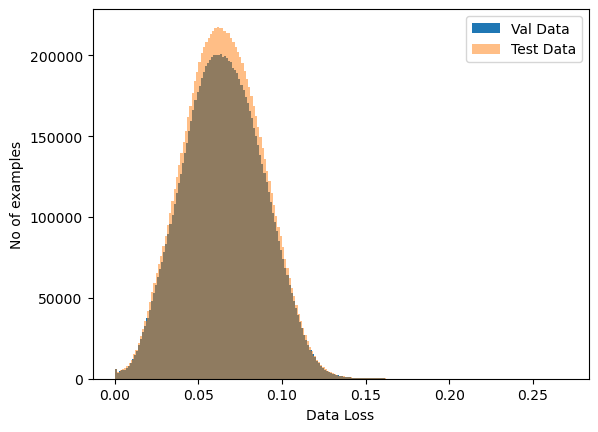

In [20]:
reconstructions = generate_reconstructions(vae, val_data)
val_loss = tf.keras.losses.mse(reconstructions, val_data)

reconstructions_test = generate_reconstructions(vae, test_data)
test_loss = tf.keras.losses.mse(reconstructions_test, test_data)

plt.hist(val_loss[None,:], bins=200, label='Val Data')
plt.hist(test_loss[None,:], bins=200, alpha=0.5, label='Test Data')
plt.xlabel("Data Loss")
plt.ylabel("No of examples")
plt.legend()
plt.show()

In [21]:
threshold = np.mean(val_loss) + np.std(val_loss)
print("Threshold ", threshold)

Threshold  0.088462375


In [22]:
threshold_anom = np.mean(test_loss) + np.std(test_loss)
print("Threshold ", threshold_anom)

Threshold  0.08846854


In [23]:
preds, loss, proba = utility.predict(vae, test_data, threshold)

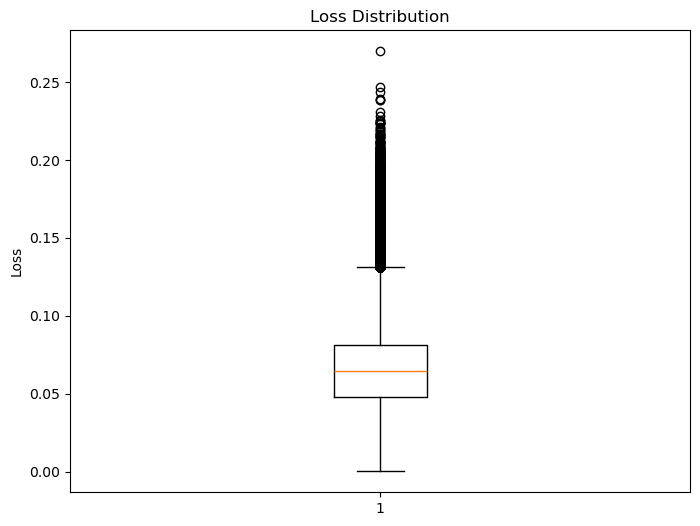

In [24]:
q1, q3, iqr, minimum, maximum = utility.boxplot_plot("Loss", loss)

In [25]:
utility.print_boxplot(q1, q3, iqr, minimum, maximum)

Q1:  0.048
Q3:  0.081
IQR:  0.033
Minimum:  0.0
Maximum:  0.131


/tmp/ipykernel_1916309/1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


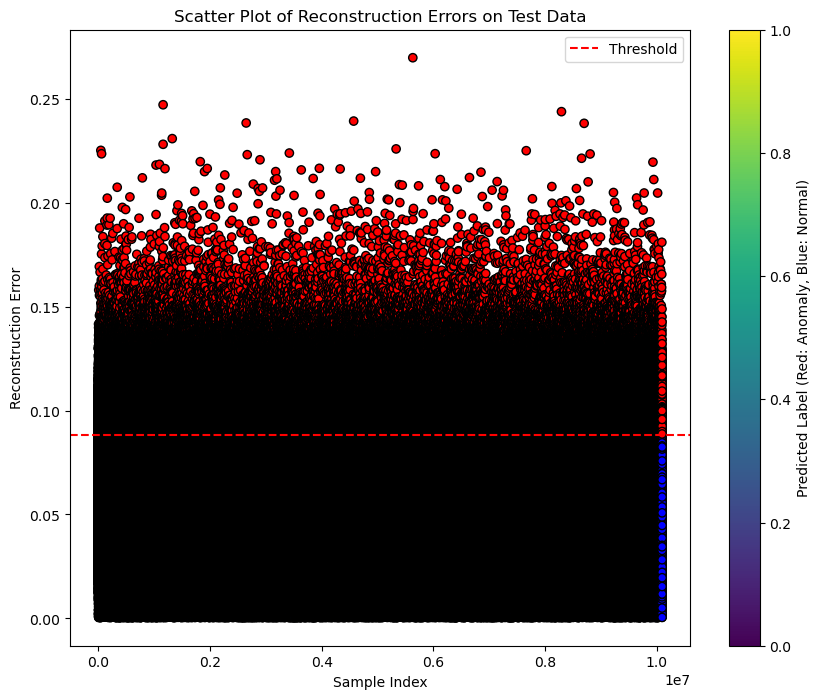

In [26]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [27]:
a, p, r, f1, report, cm = utility.get_metrics(preds, test_true_labels)

In [28]:
utility.print_stats(a, p, r, f1, report, cm)

Accuracy = 0.831511600234242
Precision = 0.9988600691098721
Recall = 0.8322609259281845
F1 = 0.9079817316744764
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.20      0.00     12000
      normal       1.00      0.83      0.91  10085253

    accuracy                           0.83  10097253
   macro avg       0.50      0.52      0.46  10097253
weighted avg       1.00      0.83      0.91  10097253

Confusion Matrix
[[   2421    9579]
 [1691691 8393562]]


True Negatives: 2421
False Positives: 9579
False Negatives: 1691691
True Positives: 8393562


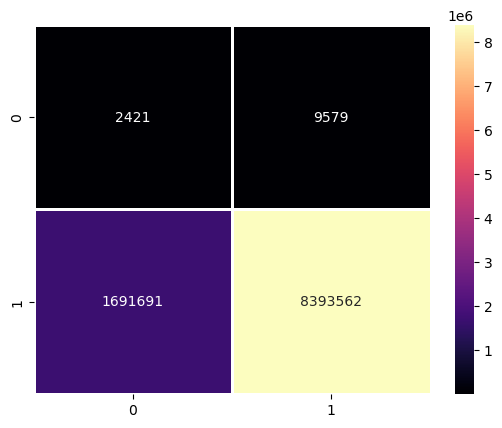

In [29]:
utility.create_heatmap(cm)

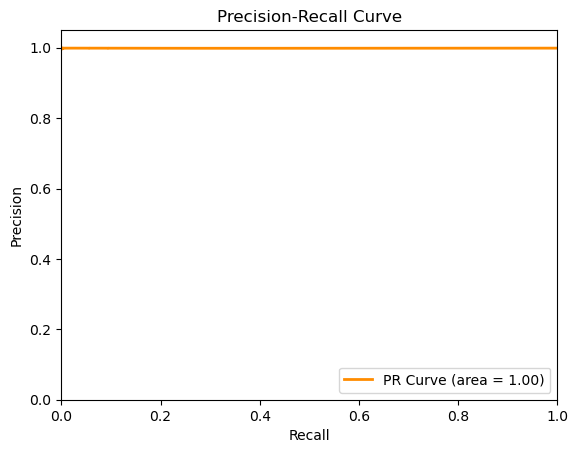

In [30]:
utility.pr_auc_plot(proba, test_true_labels)

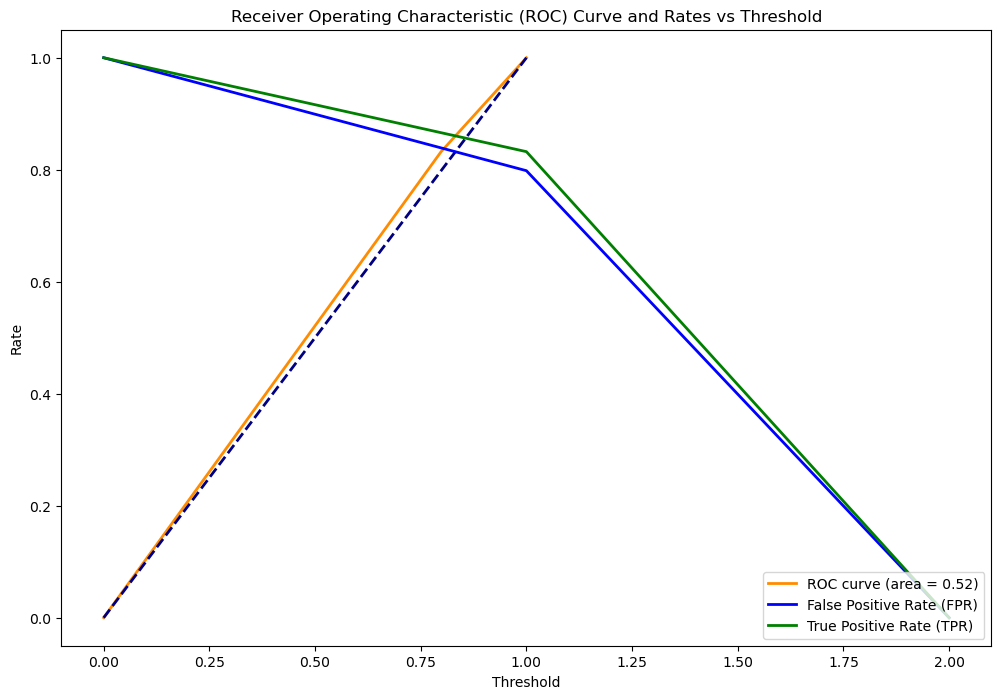

In [31]:
utility.roc_plot(preds, test_true_labels)

In [32]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to ./anomalies.json


1694112


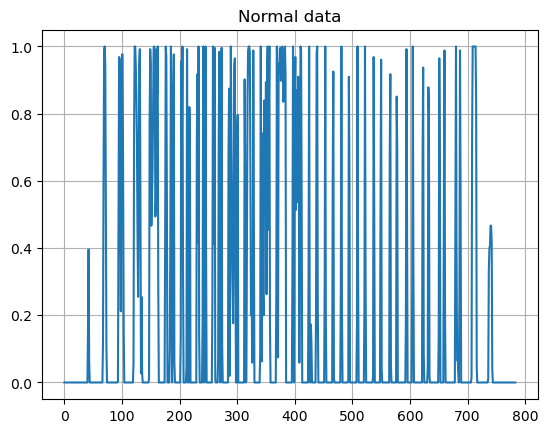

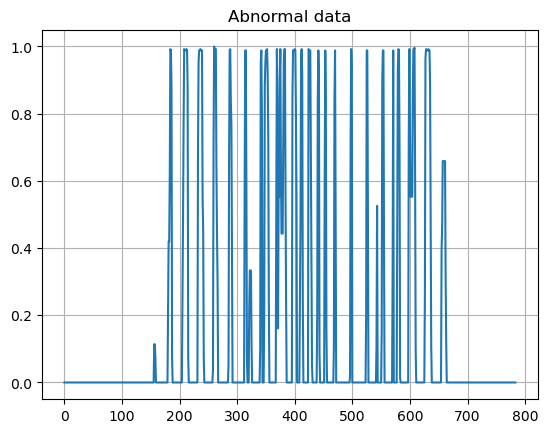

In [33]:
print(len(anomaly_indexes))

utility.plot_normalized_pixel_data(train_data, anom_data)

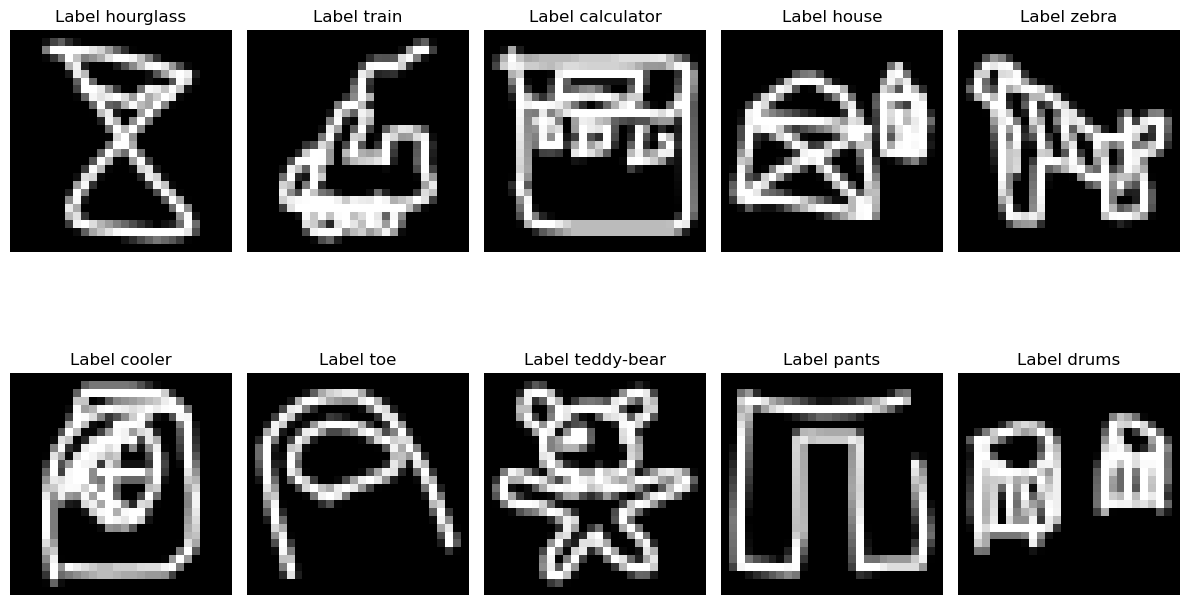

In [34]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data, test_labels)

In [35]:
stop_thread = True

thread.join()
print(f"CPU Usage: {max_cpu_usage}%")
print(f"Memory Usage: {max_memory_usage}%")

CPU Usage: 96.9%
Memory Usage: 96.1%


In [36]:
end_time = utility.time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

Total execution time: 17047.09548354149 seconds
